<a href="https://colab.research.google.com/github/yotaKawashima/Modeling_metacontrast_masking_TU/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
np.random.seed(0)

In [2]:
# define parameter
sampling_rate = 1000 #[Hz]
duration = 0.2 #[s]
time = np.arange(0, duration, 1/sampling_rate)
time = time * sampling_rate
encoding_completion_threshold = 7
interference_start_threshold = 7
stimulus_duration = 16/sampling_rate #[s]
encoding_noise = 0.1
visibility_response_threshold = 0.005
visibility_time_threshold = 50 #[ms]
time_constant = 0.05 #[s]

# define and generate target stimulus
target_intensity = 0.5
input_to_maintained_response_by_target = 1
target_onset = 16/sampling_rate #[s]
target_offset = target_onset + stimulus_duration
target_stimulus = np.zeros(len(time))
target_stimulus[int(target_onset*sampling_rate):int(target_offset*sampling_rate)] = target_intensity

# define mask
num_soa = 6
list_soa_result = np.arange(0, stimulus_duration*num_soa, stimulus_duration)
list_soa_schematic = np.array([0, stimulus_duration*3, stimulus_duration*5])
mask_intensity = 1
input_to_maintained_response_by_mask = 0.2
encoding_noise_mask = 0.15

In [3]:
# Integration over time (area under the curve)
def integrate_response(response, dt=1):
   """Integrates the response over time."""
   x = np.zeros_like(response)
   for i in range(1, len(response)):
      if i == 0:
        x[i] = response[i]
      else:
        x[i] = np.trapezoid(response[:i], dx=dt)
   return x

# Differential equation
def solve_differential_equation(I, tau=time_constant, dt=1/sampling_rate):
    """Solves the differential equation tau*dx/dt = -x + I."""
    x = np.zeros_like(time)
    for i in range(1, len(time)):
        right_side = -x[i-1] + I[i-1]
        x[i] = x[i-1] + right_side/tau*dt
    return x

def simulation_each_soa(soa, mask_intensity=0.7, num_trials=100):
  visibility = np.zeros(num_trials)
  for i_trial in range(num_trials):
    visibility[i_trial] = simulation_each_soa_one_trial(soa, mask_intensity)
  return visibility

def ignore_mask_preceeding_target(x):
  # Find the indices of targer and mask sends input to maintained response
  index_target = np.where(x == input_to_maintained_response_by_target)[0]
  index_mask = np.where(x == -input_to_maintained_response_by_mask)[0]
  # Check if -0.2 exists and if it is preceded by 1
  if index_mask.size > 0:  # Ensure -0.2 is in the array
      if index_target.size == 0 or index_target[0] > index_mask[0]:
          # If no 1 is found OR 1 appears after -0.2, replace -0.2 with 0
          x[index_mask] = 0
  return x


def simulation_each_soa_one_trial(soa, mask_intensity=0.7):
  """Perform simulation and get visible/invisible for single trial."""
  mask_onset = target_onset + soa #[s]
  mask_offset = mask_onset + stimulus_duration
  mask_stimulus = np.zeros(len(time))
  mask_stimulus[int(mask_onset*sampling_rate):int(mask_offset*sampling_rate)] = mask_intensity

  # Encoding target stimulus
  noise = np.random.normal(0.0, encoding_noise, len(target_stimulus))
  encoding_response = integrate_response(target_stimulus+noise, dt=1)

  try: # if not encoding variable does not reach the threshold
    time_crossing_threshold = \
      np.where(encoding_response > encoding_completion_threshold)[0][0]
  except:
    visibility = False
    return visibility

  input_to_maintained_response = np.zeros_like(time)
  input_to_maintained_response[int(time_crossing_threshold)] = input_to_maintained_response_by_target

  # Encoding mask
  noise = np.random.normal(0.0, encoding_noise_mask, len(target_stimulus))
  mask_effect = np.zeros(len(time))
  encoding_response_mask = \
    integrate_response(mask_stimulus+noise, dt=1)
  try:
    time_crossing_threshold_mask = \
      np.where(encoding_response_mask > interference_start_threshold)[0][0]
    #if np.random.rand() < mask_effect_probability:
    mask_effect[int(time_crossing_threshold_mask)] = input_to_maintained_response_by_mask
  except:
    pass

  # check if mask preceed target or not. If so, remove the mask effect.
  input_to_maintained_response = \
    ignore_mask_preceeding_target(input_to_maintained_response - mask_effect)
  maintained_response_with_interference = \
    solve_differential_equation(input_to_maintained_response)

  # Check visibility
  time_check_visibility = int(time_crossing_threshold+visibility_time_threshold)
  visibility = \
    maintained_response_with_interference[time_check_visibility] > visibility_response_threshold

  return visibility

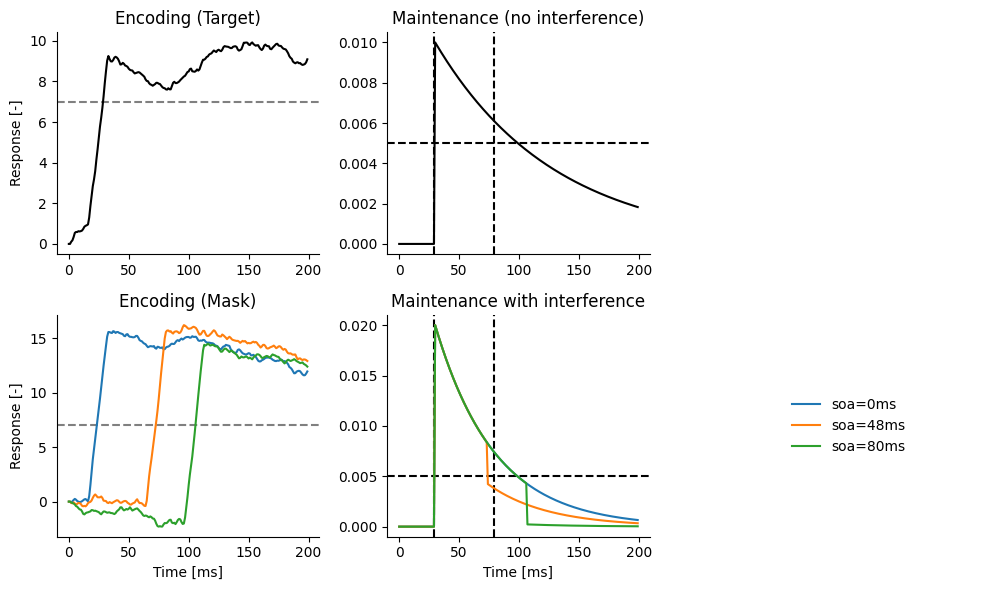

In [4]:
# Encoding target stimulus
noise = np.random.normal(0.0, encoding_noise, len(target_stimulus))
encoding_response = integrate_response(target_stimulus+noise, dt=1)
time_crossing_threshold = \
  np.where(encoding_response > encoding_completion_threshold)[0][0]
input_to_maintained_response = np.zeros_like(time)
input_to_maintained_response[int(time_crossing_threshold)] = 1

# Calculate maintained response (no inteference)
maintained_response_no_interference = \
  solve_differential_equation(input_to_maintained_response, tau=0.1)

# define mask with various SOA, encoding mask and
# calculate maintained response (with interference)
mask_stimulus_all_soa = np.zeros((len(list_soa_schematic), len(time)))
encoding_response_mask_all_soa = np.zeros((len(list_soa_schematic), len(time)))
mask_effect_all_soa = np.zeros((len(list_soa_schematic), len(time)))
time_crossing_threshold_all_soa = np.zeros(len(list_soa_schematic))
maintained_response_with_interference = \
  np.zeros((len(list_soa_schematic), len(time)))

for i_soa, soa in enumerate(list_soa_schematic):
  mask_onset = target_onset + soa #[s]
  mask_offset = mask_onset + stimulus_duration
  mask_stimulus_all_soa[i_soa, int(mask_onset*sampling_rate):int(mask_offset*sampling_rate)] = mask_intensity
  noise = np.random.normal(0.0, encoding_noise_mask, len(target_stimulus))
  encoding_response_mask_all_soa[i_soa, :] = \
    integrate_response(mask_stimulus_all_soa[i_soa, :]+noise, dt=1)
  try:
    time_crossing_threshold_all_soa[i_soa] = \
      np.where(encoding_response_mask_all_soa[i_soa, :] > interference_start_threshold)[0][0]
    mask_effect_all_soa[i_soa, int(time_crossing_threshold_all_soa[i_soa])] = input_to_maintained_response_by_mask
  except:
    pass
  # check if mask preceed target or not. If so, remove the mask effect.
  input_to_maintained_response_after_mask_effect = \
    ignore_mask_preceeding_target(input_to_maintained_response - mask_effect_all_soa[i_soa, :])
  maintained_response_with_interference[i_soa, :] = \
    solve_differential_equation(input_to_maintained_response_after_mask_effect)

# Plot the results
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

# Encoding Target
#axs[0,0].axvline(x=time_crossing_threshold, color='k', linestyle='--', label='Start maintenance')
axs[0,0].axhline(y=encoding_completion_threshold, color='grey', linestyle='--', label='Threshold')
axs[0,0].plot(time, encoding_response, color='k', label='Encoding Response')
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].set_ylabel('Response [-]')
axs[0,0].set_title('Encoding (Target)')

# Maintenance Target (before Mask interference)
axs[0,1].axvline(x=time_crossing_threshold, color='k', linestyle='--')
axs[0,1].axvline(x=time_crossing_threshold+visibility_time_threshold, color='k', linestyle='--')
axs[0,1].axhline(y=visibility_response_threshold, color='k', linestyle='--')
axs[0,1].plot(time, maintained_response_no_interference, color='k', label='Maintained Response')
axs[0,1].set_title('Maintenance (no interference)')
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)

# Encoding mask
axs[1,0].axhline(y=interference_start_threshold, color='grey', linestyle='--')
for i_soa, soa in enumerate(list_soa_schematic):
  axs[1,0].plot(time,
                encoding_response_mask_all_soa[i_soa, :],
                 label="soa={}ms".format(int(soa*sampling_rate)))
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].set_ylabel('Response [-]')
axs[1,0].set_title('Encoding (Mask)')
axs[1,0].set_xlabel('Time [ms]')

# Maintenance (with Mask interference))
axs[1,1].axvline(x=time_crossing_threshold, color='k', linestyle='--')
axs[1,1].axvline(x=time_crossing_threshold+visibility_time_threshold, color='k', linestyle='--')
axs[1,1].axhline(y=visibility_response_threshold, color='k', linestyle='--')
for i_soa, soa in enumerate(list_soa_schematic):
  axs[1,1].plot(time,
                maintained_response_with_interference[i_soa, :])
axs[1,1].set_xlabel('Time [ms]')
axs[1,1].set_title('Maintenance with interference')
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)

# add labels
handles, labels = axs[1,0].get_legend_handles_labels()
axs[1,2].legend(handles, labels, loc='center', frameon=False)
axs[1,2].set_axis_off()

fig.delaxes(axs[0,2])

plt.tight_layout()
plt.show()


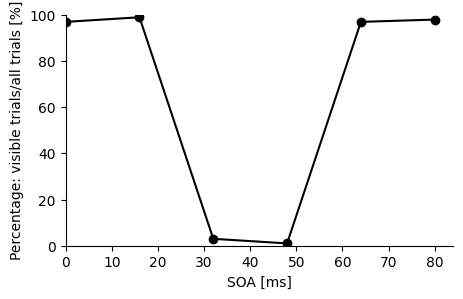

In [5]:
visibility_rate_all_soa = np.zeros(len(list_soa_result))
for i_soa, soa in enumerate(list_soa_result):
  visibility_all_trials = \
    simulation_each_soa(soa, mask_intensity=0.7, num_trials=100)
  visibility_rate_all_soa[i_soa] = \
    np.sum(visibility_all_trials) / len(visibility_all_trials)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(list_soa_result*1000, visibility_rate_all_soa*100, 'o-', color='k', label='Simulation')
ax.set_xlabel('SOA [ms]')
ax.set_ylabel('Percentage: visible trials/all trials [%]')
ax.set_ylim([0, 100.1])
ax.set_xlim([0, None])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# experimental data
You need experimental data (data_experiment.csv) to run the following.  

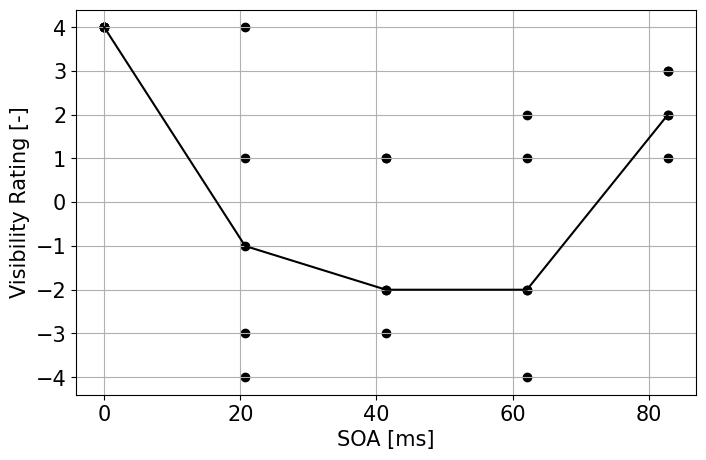

In [6]:
import pandas as pd

# load excel sheet
df = pd.read_csv('/content/data_experiment.csv')

# Extract data to plot
data = df[df['condition_name'] == 'exp1_TM2_M1'].iloc[::2]
frame_rate = float(data['frameRate'].iloc[0])
data_for_plot = data[['rating', 'soa_id', 'inner_ring_onset_relative_to_target']]
data_for_plot = data_for_plot.sort_values(by="inner_ring_onset_relative_to_target")
median_ratings = data_for_plot.groupby("inner_ring_onset_relative_to_target")["rating"].median()
data_for_plot['soa'] = round(data_for_plot['inner_ring_onset_relative_to_target'] * 1000 / frame_rate, 1)

# Plot rating as a function of stim_id
plt.figure(figsize=(8, 5))
plt.scatter(data_for_plot["soa"], data_for_plot["rating"], color="black")
plt.plot(data_for_plot['soa'].unique(), median_ratings, color="black")

plt.xlabel("SOA [ms]", fontsize=15)
plt.ylabel("Visibility Rating [-]", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.show()